In [1]:
%matplotlib inline

# Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_train_features = pd.read_csv('../hb_train_feature.csv')
df_test_features = pd.read_csv('../hb_test_feature.csv')
df_train_truth = pd.read_csv('../hb_train_truth.csv')

In [25]:
df_train_features.head()

,r11,r12,r13,r21,r22,r23,r31,r32,r33,c11,c12,c13,c21,c22,c23,c31,c32,c33
0,80.0,50.0,80.0,20.0,90.0,60.0,30.0,10.0,10.0,70.0,30.0,40.0,60.0,10.0,70.0,10.0,40.0,50.0
1,20.0,51.0,50.0,10.0,70.0,30.0,60.0,5.0,45.0,20.0,10.0,60.0,51.0,70.0,5.0,50.0,30.0,45.0
2,70.0,100.0,48.0,10.0,29.0,40.0,40.0,60.0,100.0,70.0,10.0,40.0,100.0,29.0,60.0,48.0,40.0,100.0
3,20.0,60.0,70.0,30.0,90.0,20.0,40.0,40.0,50.0,40.0,20.0,80.0,90.0,40.0,90.0,60.0,10.0,60.0
4,13.0,80.0,60.0,74.0,20.0,70.0,60.0,100.0,10.0,13.0,74.0,60.0,80.0,20.0,100.0,60.0,70.0,10.0


In [26]:
df_train_features.shape

(250, 18)

In [7]:
df_train_truth.head()

,f1,f2,f3,action
0,0.868421,0.078947,0.052632,1.0
1,0.300000,0.550000,0.150000,2.0
2,0.450000,0.000000,0.550000,3.0
3,0.421053,0.157895,0.421053,1.0
4,0.125000,0.550000,0.325000,2.0


In [15]:
df_train_features.iloc[0][9:]

c11    70.0
c12    30.0
c13    40.0
c21    60.0
c22    10.0
c23    70.0
c31    10.0
c32    40.0
c33    50.0
Name: 0, dtype: float64

In [19]:
pd.DataFrame(df_train_features.iloc[0][:9].reshape(3, 3), 
             index=['r1', 'r2', 'r3'], 
             columns=['c1', 'c2', 'c3'])

/Users/michael/anaconda3/envs/pyml/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,c1,c2,c3
r1,80.0,50.0,80.0
r2,20.0,90.0,60.0
r3,30.0,10.0,10.0


## Visualize game matrix better

In [59]:
def view_game_matrix(df_row):
    """
    View payoffs in 3x3 matrix format
    inputs
        df_row : Pandas series object, e.g. df.iloc[0]
    returns
        [row_payoffs, col_payoffs] : np.array (2x3x3)
    """
    return df_row.values.reshape(2, 3, 3)

In [60]:
view_game_matrix(df_train_features.iloc[0])

array([[[ 80.,  50.,  80.],
        [ 20.,  90.,  60.],
        [ 30.,  10.,  10.]],

       [[ 70.,  30.,  40.],
        [ 60.,  10.,  70.],
        [ 10.,  40.,  50.]]])

In [51]:
np.array(df_train_truth.iloc[0])

array([ 0.86842105,  0.07894737,  0.05263158,  1.        ])

## Distribution of plays

(array([ 42.,  36.,  44.,  30.,  23.,  24.,  22.,  13.,  14.,   2.]),
 array([ 0.        ,  0.09756098,  0.19512195,  0.29268293,  0.3902439 ,
         0.48780488,  0.58536585,  0.68292683,  0.7804878 ,  0.87804878,
         0.97560976]),
 <a list of 10 Patch objects>)

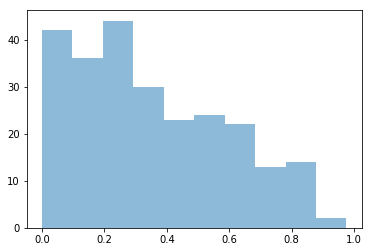

In [99]:
plt.hist(df_train_truth['f1'], alpha=0.5)
# plt.hist(df_train_truth['f2'], alpha=0.5)
# plt.hist(df_train_truth['f3'], alpha=0.5)
# plt.show()

## Idea 1: Convolutions

If the players see a bimatrix game in the matrix format (even if they don't), then they might pick actions based on some saliency to the payoffs. We can then think of how we would want to classify a payoff. 

They may consider their own payoffs, but also the payoffs of the opponent (several strategies involve trying to pick the same or trying to make the opponent well off too). So aside from their own payoffs we can have a matrix that shows the differences.

Would have a weight associated with each matrix item?

In [62]:
# Example, the payoffs of a single game
payoff_game_0 = view_game_matrix(df_train_features.iloc[0])
print(payoff_game_0)

[[[ 80.  50.  80.]
  [ 20.  90.  60.]
  [ 30.  10.  10.]]

 [[ 70.  30.  40.]
  [ 60.  10.  70.]
  [ 10.  40.  50.]]]


In [63]:
# The differences of them
payoff_game_0[0] - payoff_game_0[1]

array([[ 10.,  20.,  40.],
       [-40.,  80., -10.],
       [ 20., -30., -40.]])

In [68]:
# Can also consider differences of the max
np.array([
    payoff_game_0[0] - np.max(payoff_game_0[0]),
    payoff_game_0[1] - np.max(payoff_game_0[1])])

array([[[-10., -40., -10.],
        [-70.,   0., -30.],
        [-60., -80., -80.]],

       [[  0., -40., -30.],
        [-10., -60.,   0.],
        [-60., -30., -20.]]])

In [69]:
df_train_truth.iloc[0]

f1        0.868421
f2        0.078947
f3        0.052632
action    1.000000
Name: 0, dtype: float64

In [74]:
def predict_max(df_row):
    payoff = view_game_matrix(df_row)
    payoff_diff = np.abs(payoff[0] - payoff[1])
    payoff_r_diff = payoff[0] - np.max(payoff[0])
    payoff_c_diff = payoff[1] - np.max(payoff[1])
    print(payoff_diff)
    print(payoff_r_diff)
    print(payoff_c_diff)


In [79]:
predict_max(df_train_features.iloc[3])

[[ 20.  40.  10.]
 [ 60.  50.  70.]
 [ 20.  30.  10.]]
[[-70. -30. -20.]
 [-60.   0. -70.]
 [-50. -50. -40.]]
[[-50. -70. -10.]
 [  0. -50.   0.]
 [-30. -80. -30.]]


In [80]:
df_train_truth.iloc[3]

f1        0.421053
f2        0.157895
f3        0.421053
action    1.000000
Name: 3, dtype: float64

## Idea 2: Generate more data

We don't have that many games (just 250?). But if we can learn the generate similar games then we could (1) predict the actual outcomes for different ones and (2) generate more training data to support a deep learning approach.


Could also try augmenting the data, e.g. "rotations" and also rotate the frequencies as well